# S&P 500 Stock Analysis using Machine Learning (Clustering) 

## Business Understanding

The objective of this project is to perform an unsupervised segmentation of companies based on key financial indicators, with the goal of identifying distinct groups or "market player types" that exhibit similar behavior across features such as trading volume, stock price, market capitalization, EBITDA, revenue growth, and portfolio weight.

By leveraging KMeans clustering and feature standardization, the project aims to:

- Detect underlying patterns in financial performance and market presence
- Group companies into data-driven clusters that represent real-world investment types
- Enable analysts, portfolio managers, and strategy teams to make targeted decisions based on the clusters

# Imports data handling, visualization, statistics and ML libraries.

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    auc,
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
    roc_curve
)

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)

# All Constants

In [17]:
RAW_DATA_DIR = os.path.join('..', 'data')
SAVED_MODEL_DIR = os.path.join('..', 'saved_models')
SNP500_COMPANIES_FILE_PATH = os.path.join(RAW_DATA_DIR, 'sp500_companies.csv')
SNP500_INDEX_FILE_PATH     = os.path.join(RAW_DATA_DIR, 'sp500_index.csv')
SNP500_STOCKS_FILE_PATH    = os.path.join(RAW_DATA_DIR, 'sp500_stocks.csv')


## Load Datasets and split in train and test.

In [ ]:
def loadDataset(paths):
    """
    Loads and processes S&P 500 datasets including index, companies, and stock data.

    Parameters:
    - paths (list): A list of three file paths [index_path, companies_path, stocks_path]

    Returns:
    - train (DataFrame): Training portion of the merged dataset
    - test (DataFrame): Testing portion of the merged dataset
    - index_df (DataFrame): S&P 500 index data
    - merged_df (DataFrame): Merged dataset of stock and company information
    """
    index = paths[0]    # SP_500 Index
    companies = paths[1] # SP_500 Companies
    stocks = paths[2] # SP_500 Stocks

    # Load datasets 
    index_df = pd.read_csv(index, parse_dates=['Date'])
    companies_df = pd.read_csv(companies)
    stocks_df = pd.read_csv(stocks, parse_dates=['Date'])
    stocks_df = stocks_df[stocks_df['Close'].isnull() == False]

    # Merge datasets for training
    merged_df = stocks_df.merge(companies_df, on='Symbol', how='left')

    print(f'Shape of the merged dataset: {merged_df.shape}')

    # train test split
    train, test = train_test_split(merged_df, test_size=0.2, random_state=42)

    # Train data
    print(f'Shape of Train dataset: {train.shape}')

    # Test data
    print(f'Shape of Test dataset: {test.shape}')

    return train, test, index_df, merged_df

In [19]:
file_paths = [SNP500_INDEX_FILE_PATH, SNP500_COMPANIES_FILE_PATH, SNP500_STOCKS_FILE_PATH]
stocks, stocks_test, df_sp500_index, df_stock_compeny_master = loadDataset(file_paths)

Shape of the merged dataset: (617831, 23)
Shape of Train dataset: (494264, 23)
Shape of Test dataset: (123567, 23)


# Clustring

In [20]:
def selectFeatures(df):
    # Text Features
    text_features = ['Symbol','Sector']

    # Numerical Features
    num_features = ['Volume', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'Weight']

    # Prepare dataset for clustering
    return text_features, num_features, df[text_features + num_features]

text_features, num_features, stocks = selectFeatures(stocks)  
stocks.head()

,Symbol,Sector,Volume,Currentprice,Marketcap,Ebitda,Revenuegrowth,Weight
17737,ALB,Basic Materials,2147300.0,88.65,10419920896,-9.350780e+08,-0.414,0.000187
59311,AJG,Financial Services,533600.0,283.10,70719234048,3.382200e+09,0.119,0.001272
24725,GOOG,Communication Services,136754676.0,192.96,2351623045120,1.234700e+11,0.151,0.042309
32251,AMZN,Consumer Cyclical,158006000.0,224.92,2365033807872,1.115830e+11,0.110,0.042550
246591,FAST,Industrials,2078900.0,74.82,42863333376,1.693200e+09,0.035,0.000771


## Data Preparation

#### Methods for Feature engineering

Based on the data understanding, following feature engienering techniques are applied

1. Remove duplicate samples
2. Impute missing values by Mean and Linear Regression
3. Log Transformation to balance the skewness
4. Normalization using Standard Scalar

In [ ]:
def checkForMissingValues(df):
    # Find list of missing values across all features
    result = pd.concat([df.isnull().sum(),round(df.isnull().mean()*100,2)],axis=1)
    result = result.rename(index=str,columns={0:'total missing',1:'proportion'})
    result.sort_values(by='total missing',ascending=False,inplace=True)
    return result

# Method to drop all duplicate rows
def remove_duplicates(df):
    print("Removing Duplicate Rows")
    duplicate_rows = df[df.duplicated()]
    print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
    df.drop_duplicates()
    print(f"Shape after removing duplicates: {df.shape}")
    return df

# Impute by Mean
def imputeByMean(df, feature, groupby_col):
    print("Imputing missing values by Mean")
    df[feature] = df.groupby(groupby_col)[feature].transform(lambda x: x.fillna(x.mean()))
    return df

# Impute by Linear Regression
def imputeByRegression(df, features, target):
    print("Imputing missing values by Linear Regression")
    # Prepare the DataFrame for regression
    ebitda_df = df[features + [target]]

    # df[df['Ebitda'].notnull()]
    train = ebitda_df[ebitda_df[target].notnull()]
    test = ebitda_df[ebitda_df[target].isnull()]

    model = LinearRegression()
    model.fit(train[features], train[target])

    # Predict Ebitda for stocks with missing values
    df.loc[df[target].isnull(), target] = model.predict(test[features])

    result = checkForMissingValues(stocks)
    print(result)
    
    return df

# Log Transformation
def logTransform(df, features):
    print("Applying Log Transformation")
    for feature in features:
        df[feature] = np.log1p(df[feature])
    
    # Plot the distribution of numerical features after log transformation
    plot_feature_distribution(stocks, num_features)
    return df

# Normalize Features
def normalize(df, features):
    print("Normalizing Features")
    scaler = StandardScaler()
    df[features] = scaler.fit_transform(df[features])
    return df

# Plot the distribution of numerical features
def plot_feature_distribution(df, features):
    fig, ax = plt.subplots(2, 3, figsize=(18, 8))
    plt.subplots_adjust(top = 0.99, bottom=0.05, hspace=1, wspace=0.4)
    ax = ax.flatten()
    for i,col in enumerate(features):
        kde = stats.gaussian_kde(stocks[col])
        x = np.linspace(stocks[col].min(), stocks[col].max(), 1000)
        ax[i].plot(x, kde(x), color='red')
        ax[i].hist(stocks[col], bins=50, density=True, alpha=0.75, color='skyblue', edgecolor='black')
        ax[i].set_title(f'histogram for {col}')
        ax[i].set_xlabel(col)
        ax[i].set_ylabel('Density')

In [ ]:
def performFeatureEngineeing(stocks_df):
    # Drop all duplicate rows
    stocks_cleaned = remove_duplicates(stocks_df)

    # Impute revenue growth by taking a mean of revenue growth for each sector
    stocks_cleaned = imputeByMean(stocks_cleaned,
                        feature=['Revenuegrowth'],
                        groupby_col='Sector')
    
    # Impute Ebitda by regression
    stocks_cleaned = imputeByRegression(stocks_cleaned, features=['Marketcap', 'Revenuegrowth', 'Weight'], target='Ebitda')

    # Log Transform selected features
    stocks_cleaned = logTransform(stocks_cleaned, ['Volume', 'Currentprice', 'Marketcap', 'Revenuegrowth', 'Weight'])

    # Normalize numerical features
    stocks_cleaned = normalize(stocks_cleaned, num_features)

    return stocks_cleaned


Removing Duplicate Rows
Number of duplicate rows: 29671
Shape after removing duplicates: (494264, 8)
Imputing missing values by Mean
Imputing missing values by Linear Regression
               total missing  proportion
Symbol                     0         0.0
Sector                     0         0.0
Volume                     0         0.0
Currentprice               0         0.0
Marketcap                  0         0.0
Ebitda                     0         0.0
Revenuegrowth              0         0.0
Weight                     0         0.0
Applying Log Transformation
Normalizing Features


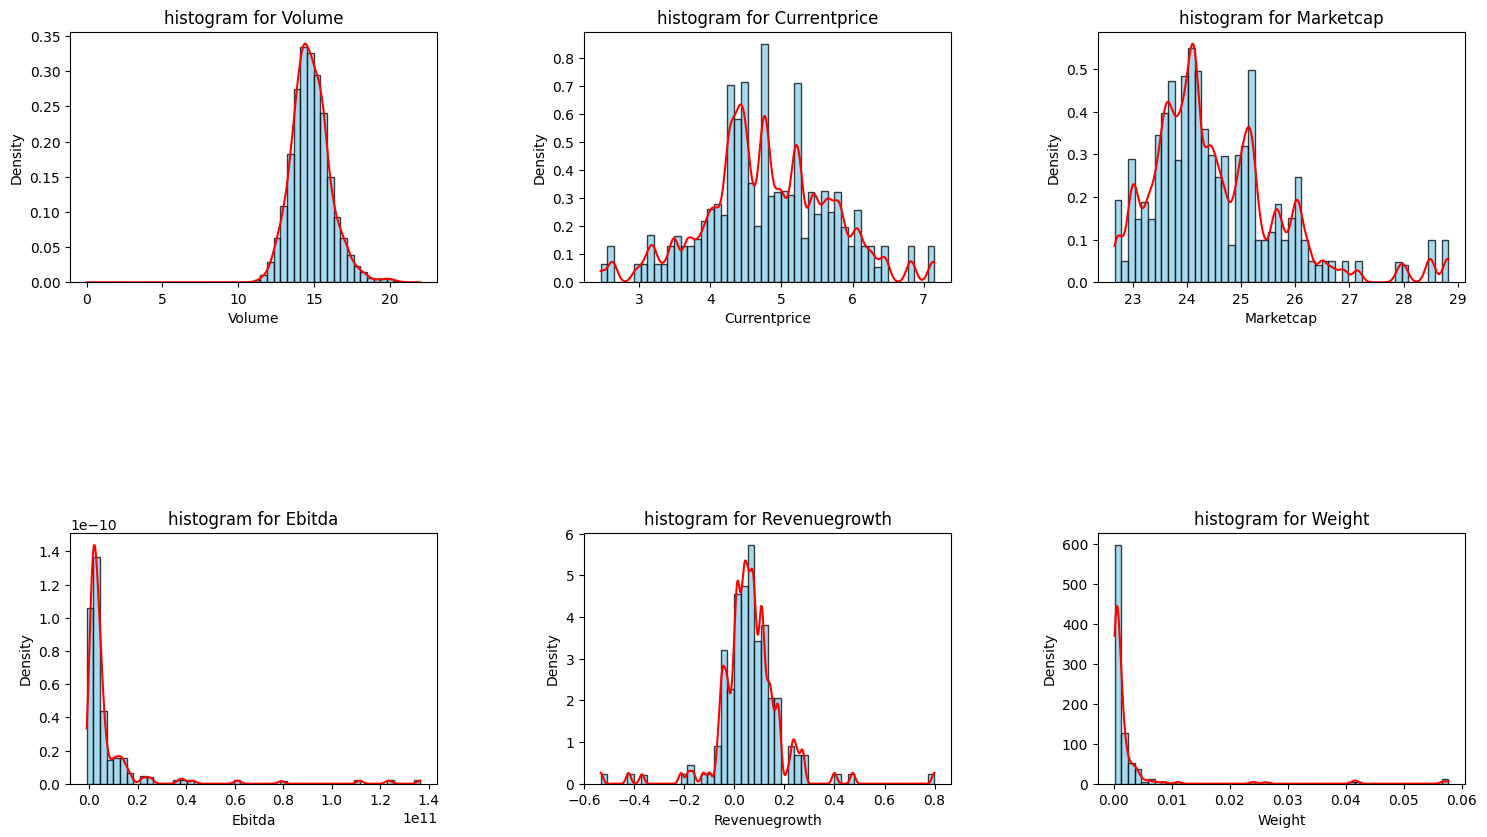

In [23]:
stocks = performFeatureEngineeing(stocks)

In [24]:

stocks.head()

,Symbol,Sector,Volume,Currentprice,Marketcap,Ebitda,Revenuegrowth,Weight
17737,ALB,Basic Materials,-0.169948,-0.344756,-1.229153,-0.493463,-4.601036,-0.304722
59311,AJG,Financial Services,-1.238181,0.953903,0.356761,-0.259420,0.396731,-0.169714
24725,GOOG,Communication Services,3.017120,0.524166,3.258733,6.250634,0.614573,4.832558
32251,AMZN,Consumer Cyclical,3.127942,0.695902,3.263442,5.606231,0.334340,4.861384
246591,FAST,Industrials,-0.194785,-0.533406,-0.057896,-0.350982,-0.206165,-0.232064


## Modelling 

In [25]:
# Function to perform KMeans clustering
# :param data: DataFrame containing the features for clustering
# :param n_clusters: Number of clusters to form
def kmeans_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0)
    kmeans.fit(data)
    return kmeans, kmeans.labels_, kmeans.inertia_

In [26]:

inertias = []
knn_labels = []
train_eval = stocks.copy()

# Perform KMeans clustering for different values of k
for n_clusters in range(2, 8):
    kmeans, labels, inertia = kmeans_clustering(stocks[num_features], n_clusters)
    inertias.append(inertia)
    knn_labels.append(labels)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(stocks[num_features], labels)
    print(f'Number of clusters: {n_clusters}, Inertia: {inertia}, Silhouette Score: {silhouette_avg}')
    
    # Add cluster labels to the DataFrame
    stocks[f'cluster_{n_clusters}'] = labels

    # Save each KMeans model with the cluster count in the filename
    model_path = os.path.join(SAVED_MODEL_DIR, f'kmeans_k{n_clusters}.pkl')
    joblib.dump(kmeans, model_path)



Number of clusters: 2, Inertia: 1838627.0440620692, Silhouette Score: 0.7394423302193156
Number of clusters: 3, Inertia: 1438760.4198052427, Silhouette Score: 0.2655336957931047
Number of clusters: 4, Inertia: 1120374.1489023985, Silhouette Score: 0.27132620229406756
Number of clusters: 5, Inertia: 1007433.6046159667, Silhouette Score: 0.2357965111169148
Number of clusters: 6, Inertia: 899358.3671451845, Silhouette Score: 0.2394633420893158
Number of clusters: 7, Inertia: 812796.2214402489, Silhouette Score: 0.2581823855721697


While Silhoutte score is high for K=2, it might be over simplified if we go ahead with just 2 clusters. 

The elbow plot shows k=4 or k=5. Between these two values, k=5 could provide more balanced set of clusters.

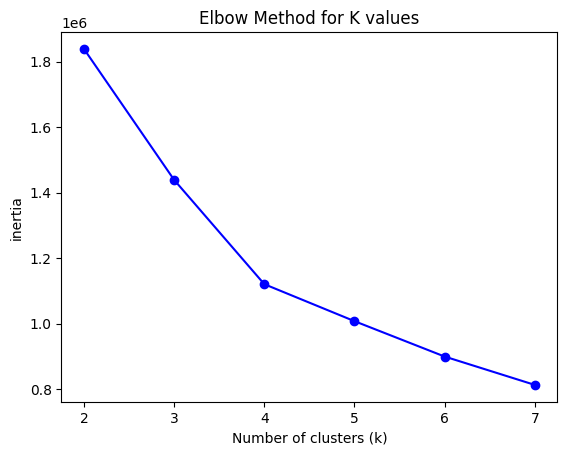

In [27]:
# Plot the elbow curve
plt.plot(range(2, 8), inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('inertia')
plt.title('Elbow Method for K values')
plt.show()

### Model training with optimal K=5

In [28]:
kmeans, labels, inertia = kmeans_clustering(stocks[num_features], 5)

# Calculate silhouette score
silhouette_avg = silhouette_score(stocks[num_features], labels)

# Calculate silhouette score
print(f'Number of clusters: 5, Inertia: {inertia}, Silhouette Score: {silhouette_avg}')

# Add cluster labels to the DataFrame
stocks[f'optimal_cluster'] = labels


Number of clusters: 5, Inertia: 1007433.6046159667, Silhouette Score: 0.2357965111169148


In [29]:
stocks.head()

,Symbol,Sector,Volume,Currentprice,Marketcap,Ebitda,Revenuegrowth,Weight,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,optimal_cluster
17737,ALB,Basic Materials,-0.169948,-0.344756,-1.229153,-0.493463,-4.601036,-0.304722,0,2,3,3,3,3,3
59311,AJG,Financial Services,-1.238181,0.953903,0.356761,-0.259420,0.396731,-0.169714,0,0,2,2,5,5,2
24725,GOOG,Communication Services,3.017120,0.524166,3.258733,6.250634,0.614573,4.832558,1,1,1,1,1,1,1
32251,AMZN,Consumer Cyclical,3.127942,0.695902,3.263442,5.606231,0.334340,4.861384,1,1,1,1,1,1,1
246591,FAST,Industrials,-0.194785,-0.533406,-0.057896,-0.350982,-0.206165,-0.232064,0,2,3,4,2,2,4


Find the average and number of samples for Cluster_5

In [30]:
# Choose Cluster 5 based on the elbow method
cluster_summary = stocks.groupby('optimal_cluster')[num_features].mean().reset_index()
cluster_summary

,optimal_cluster,Volume,Currentprice,Marketcap,Ebitda,Revenuegrowth,Weight
0,0,0.928660,0.163198,1.143483,0.358298,0.036289,0.195873
1,1,2.451670,0.878046,3.307410,5.145280,1.679028,5.330215
2,2,-0.759240,0.923710,-0.090185,-0.271086,0.312403,-0.215024
3,3,-0.539458,-0.373151,-0.815838,-0.326333,-0.886836,-0.283786
4,4,0.347141,-0.957226,-0.432637,-0.254475,0.119030,-0.256326


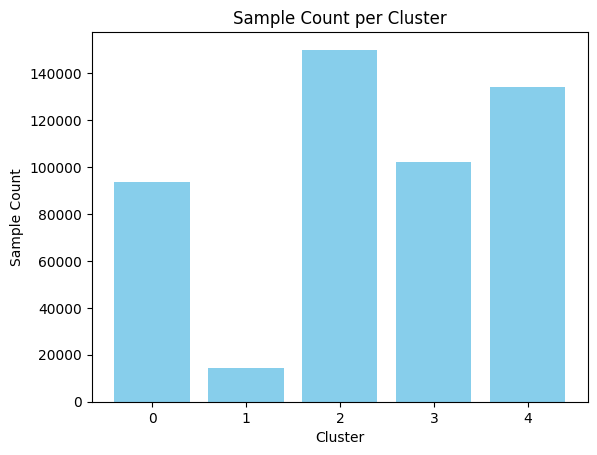

In [31]:
# find the number of samples in eaach cluster
cluster_counts = stocks['optimal_cluster'].value_counts().sort_index()
cluster_summary['sample_count'] = cluster_counts
plt.bar(cluster_summary['optimal_cluster'], cluster_summary['sample_count'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Sample Count')
plt.title('Sample Count per Cluster')
plt.xticks(rotation=0)
plt.show()

The PCA plot provides the visualization of various clusters

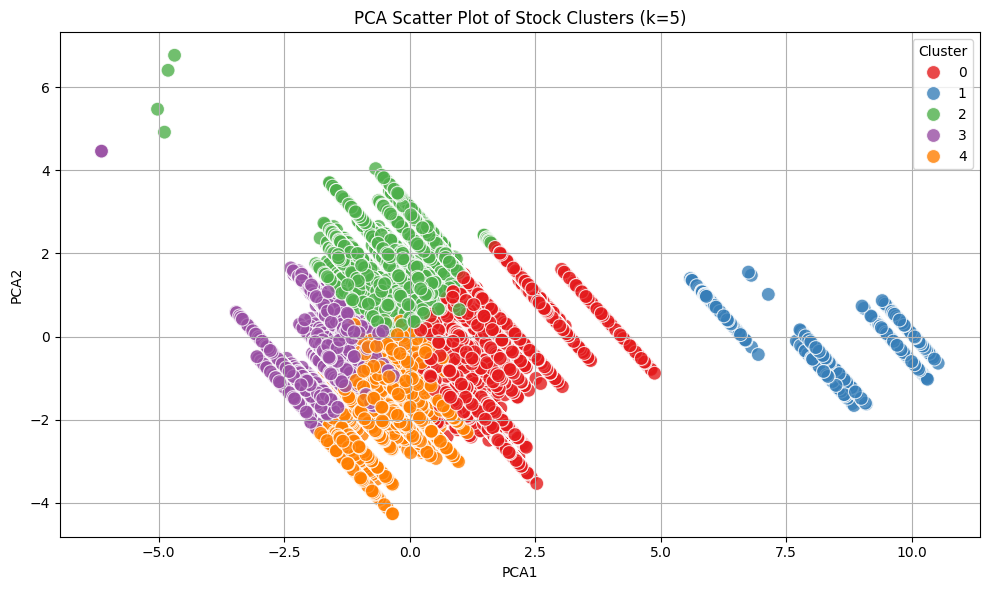

In [32]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(stocks[num_features])
stocks['PCA1'] = X_pca[:, 0]
stocks['PCA2'] = X_pca[:, 1]

# Plot PCA Visualization using 'optimal_cluster' 
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=stocks,
    x='PCA1',
    y='PCA2',
    hue='optimal_cluster',
    palette='Set1',
    s=100,
    alpha=0.8
)

plt.title('PCA Scatter Plot of Stock Clusters (k=5)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

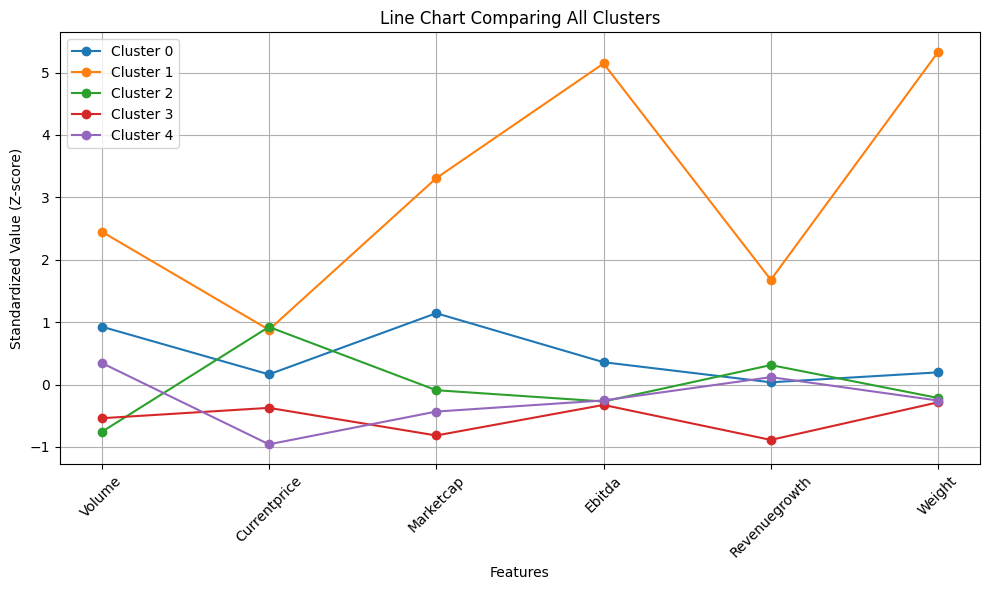

In [33]:
# Plot the mean values of each feature for each cluster
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(num_features, cluster_summary.loc[i, num_features], marker='o', label=f'Cluster {i}')
plt.title('Line Chart Comparing All Clusters')
plt.xlabel('Features')
plt.ylabel('Standardized Value (Z-score)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Cluster by Cluster Interpretation  
  
**Cluster 0:** Steady Performers with Above average on all parameters  
**Cluster 1**: Market Giants with way above average performance on all parameters - Amazon, Nvidia, Google stocks fall  here.  
**Cluster 2**: Over valued stocks with weak foundation on paramters such as volume, market, Ebitda and weight and above average in current price with slightly above average revenue growth  
**Cluster 3**: Low value, Low growth stocks with weak fundamentals and growth - Penny stocks mostly fall here  
**Cluster 4**: Average/Neutral performers - above average volume and slightly above average Revenue growth. weak in other paramters.  

In [34]:
# High growth stocks
stocks[stocks['optimal_cluster'] == 1][['Symbol', 'Sector']]

,Symbol,Sector
24725,GOOG,Communication Services
32251,AMZN,Consumer Cyclical
32628,AMZN,Consumer Cyclical
27293,GOOG,Communication Services
411983,NVDA,Technology
...,...,...
394070,MSFT,Technology
387261,META,Communication Services
25939,GOOG,Communication Services
411357,NVDA,Technology


In [35]:
# Penny stocks
stocks[stocks['optimal_cluster'] == 3][['Symbol', 'Sector']]

,Symbol,Sector
17737,ALB,Basic Materials
594959,WEC,Utilities
417670,OMC,Communication Services
349470,JBHT,Industrials
494,AOS,Industrials
...,...,...
347449,JBHT,Industrials
327069,IFF,Basic Materials
329365,IFF,Basic Materials
278167,GPN,Industrials


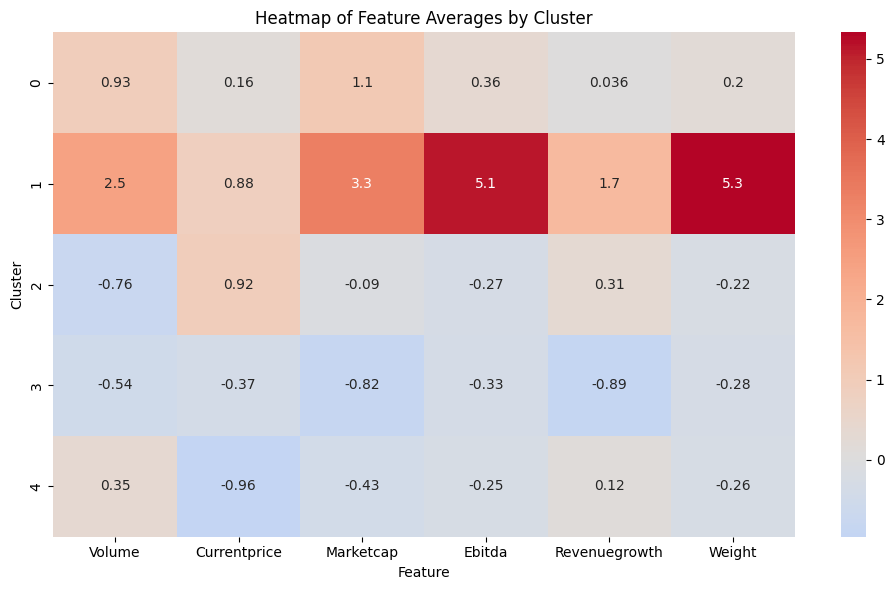

In [36]:
# Heat map of feature averages by cluster
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary[num_features], annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Feature Averages by Cluster')
plt.xlabel('Feature')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

The heatmap represents the z-scores of each dimension across each cluster.   

For instance, among all clusters, Revenue growth is highest for cluster 1. Based on the line chart, cluster 1 has market influencers or high growth stocks like amazon or google. 

Another instance is the negative scores for all parameters for Cluster 3 which indicates weak foundation across all paramters. 

## Model Evaluation

In [37]:
stocks_test.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Exchange,Shortname,...,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
426772,2015-02-25,PKG,60.593231,82.099998,82.760002,81.669998,82.639999,585900.0,NYQ,Packaging Corporation of Americ,...,227.98,20473718784,1.625000e+09,0.127,Lake Forest,IL,United States,14900.0,Packaging Corporation of America manufactures ...,0.000368
456261,2012-07-17,PPG,42.514153,52.064999,52.160000,50.959999,51.294998,1810400.0,NYQ,"PPG Industries, Inc.",...,120.21,27888719872,2.870000e+09,-0.015,Pittsburgh,PA,United States,53000.0,"PPG Industries, Inc. manufactures and distribu...",0.000502
239251,2022-08-12,FFIV,172.649994,172.649994,172.880005,170.550003,170.880005,363800.0,NMS,"F5, Inc.",...,252.25,14785608704,7.820980e+08,0.056,Seattle,WA,United States,NaN,"F5, Inc. provides multicloud application secur...",0.000266
50228,2021-10-26,ANSS,376.470001,376.470001,381.220001,375.920013,377.160004,225100.0,NMS,"ANSYS, Inc.",...,338.38,29591330816,8.361090e+08,0.312,Canonsburg,PA,United States,6400.0,"ANSYS, Inc. develops and markets engineering s...",0.000532
296391,2014-09-11,HLT,48.341377,50.971680,51.710400,50.602322,50.889599,3296248.0,NYQ,Hilton Worldwide Holdings Inc.,...,249.42,60803608576,2.457000e+09,0.063,McLean,VA,United States,178000.0,"Hilton Worldwide Holdings Inc., a hospitality ...",0.001094


In [38]:
text_features, num_features, x_test = selectFeatures(stocks_test)  
x_test.head()


,Symbol,Sector,Volume,Currentprice,Marketcap,Ebitda,Revenuegrowth,Weight
426772,PKG,Consumer Cyclical,585900.0,227.98,20473718784,1.625000e+09,0.127,0.000368
456261,PPG,Basic Materials,1810400.0,120.21,27888719872,2.870000e+09,-0.015,0.000502
239251,FFIV,Technology,363800.0,252.25,14785608704,7.820980e+08,0.056,0.000266
50228,ANSS,Technology,225100.0,338.38,29591330816,8.361090e+08,0.312,0.000532
296391,HLT,Consumer Cyclical,3296248.0,249.42,60803608576,2.457000e+09,0.063,0.001094


Removing Duplicate Rows
Number of duplicate rows: 2026
Shape after removing duplicates: (123567, 8)
Imputing missing values by Mean
Imputing missing values by Linear Regression
                 total missing  proportion
Symbol                       0         0.0
Sector                       0         0.0
Volume                       0         0.0
Currentprice                 0         0.0
Marketcap                    0         0.0
Ebitda                       0         0.0
Revenuegrowth                0         0.0
Weight                       0         0.0
cluster_2                    0         0.0
cluster_3                    0         0.0
cluster_4                    0         0.0
cluster_5                    0         0.0
cluster_6                    0         0.0
cluster_7                    0         0.0
optimal_cluster              0         0.0
PCA1                         0         0.0
PCA2                         0         0.0
Applying Log Transformation


C:\Users\atul1\AppData\Local\Temp\ipykernel_10376\3201287392.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df.groupby(groupby_col)[feature].transform(lambda x: x.fillna(x.mean()))
C:\Users\atul1\AppData\Local\Temp\ipykernel_10376\3201287392.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = np.log1p(df[feature])


Normalizing Features


C:\Users\atul1\AppData\Local\Temp\ipykernel_10376\3201287392.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features] = scaler.fit_transform(df[features])


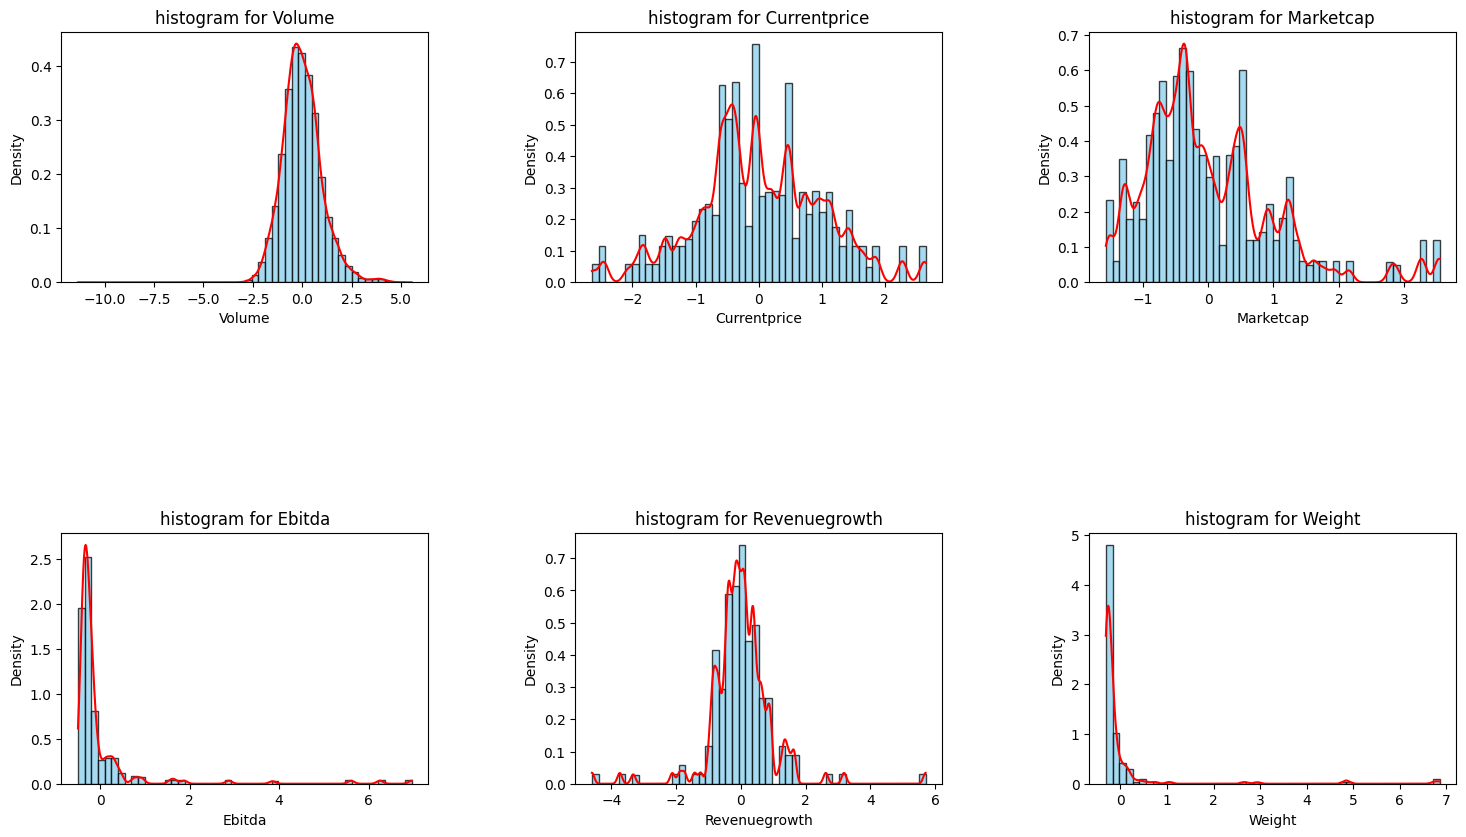

In [39]:
x_test = performFeatureEngineeing(x_test)

In [40]:
x_test

,Symbol,Sector,Volume,Currentprice,Marketcap,Ebitda,Revenuegrowth,Weight
426772,PKG,Consumer Cyclical,-1.170384,0.716319,-0.667175,-0.354878,0.455307,-0.283456
456261,PPG,Basic Materials,-0.304062,-0.000259,-0.412269,-0.288428,-0.592149,-0.266960
239251,FFIV,Technology,-1.536328,0.829805,-0.935612,-0.399866,-0.050801,-0.296111
50228,ANSS,Technology,-1.904970,1.159580,-0.363397,-0.396983,1.637478,-0.263172
296391,HLT,Consumer Cyclical,0.156099,0.817146,0.230542,-0.310471,0.000586,-0.193762
...,...,...,...,...,...,...,...,...
174345,DFS,Financial Services,-0.362518,0.408041,-0.046110,-0.206091,3.205253,-0.232292
476216,PHM,Consumer Cyclical,0.365519,-0.094119,-0.583293,-0.239394,0.392946,-0.278579
314029,INCY,Healthcare,-0.782057,-0.621318,-1.025300,-0.437312,1.185935,-0.299501
451330,PNW,Utilities,-1.009241,-0.387372,-1.286668,-0.336028,0.123987,-0.307516


In [41]:
# Predict cluster labels for the cleaned test data
test_labels = kmeans.predict(x_test[num_features])

score = silhouette_score(x_test[num_features], test_labels)
print("Silhouette Score on Test:", score)

Silhouette Score on Test: 0.23528653181069778


In [42]:
x_test_df = x_test.copy()
x_test_df['cluster'] = test_labels

In [43]:
x_test_df['cluster'].unique()

array([2, 3, 4, 1, 0], dtype=int32)

In [44]:
x_test_df[x_test_df['cluster'] == 1][['Symbol', 'Sector']]

,Symbol,Sector
392883,MSFT,Technology
391663,MSFT,Technology
33740,AMZN,Consumer Cyclical
28107,GOOG,Communication Services
392244,MSFT,Technology
...,...,...
387765,META,Communication Services
410975,NVDA,Technology
33216,AMZN,Consumer Cyclical
33752,AMZN,Consumer Cyclical


In [45]:
x_test_df[x_test_df['cluster'] == 3][['Symbol', 'Sector']]

,Symbol,Sector
456261,PPG,Basic Materials
176669,DG,Consumer Defensive
18009,ALB,Basic Materials
456539,PPG,Basic Materials
455680,PPG,Basic Materials
...,...,...
593313,WEC,Utilities
81974,BBY,Consumer Cyclical
52324,ADM,Consumer Defensive
278750,GPN,Industrials


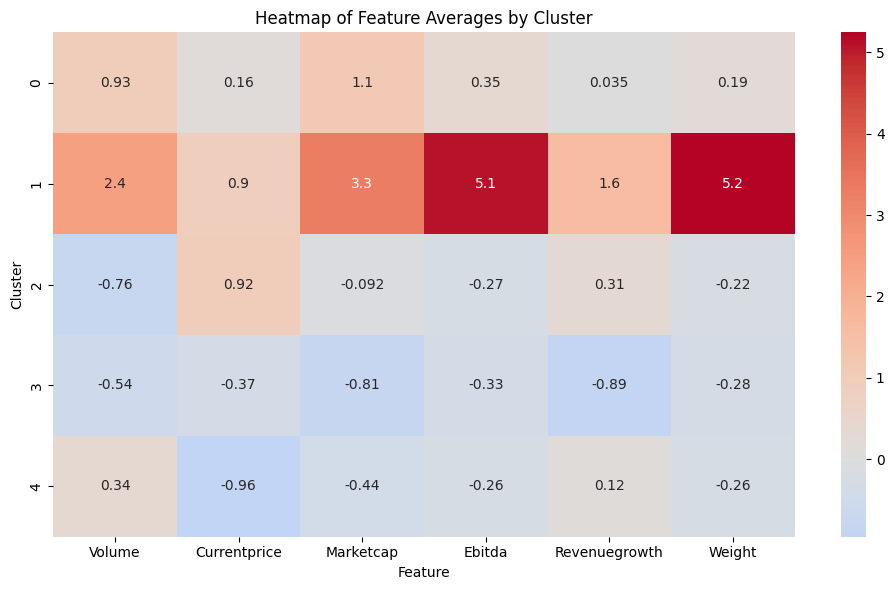

In [46]:
test_cluster_summary = x_test_df.groupby('cluster')[num_features].mean().reset_index()
# Heat map of feature averages by cluster
plt.figure(figsize=(10, 6))
sns.heatmap(test_cluster_summary[num_features], annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Feature Averages by Cluster')
plt.xlabel('Feature')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

## Conclusion

The silhoutte score indicates that the clusterse are reasonably good though there are some overlaps.

The clusters provide a good investment strategies for customers. 

**Cluster 0:**    
Steady Performers   
Business Insight: Suitable for balanced investment strategies seeking consistency

**Cluster 1**:  
Market Giants    
Business Insight: Blue-chip, high-cap firms. Ideal for core holdings and low-risk institutional investing.

**Cluster 2**:   
Over valued stocks with weak foundation   
Business Insight: Caution advised on trading these stocks

**Cluster 3**:   
Low value, Low growth stocks   
Business Insight: may be good for short team. These are distressed stocks not advisable for long term investing.

**Cluster 4**:   
Average/Neutral performers  
Business Insight: Considered safe stocks but not exciting. 

# Quantitative Models for Stock Outperformance

In [47]:
def de_index(df):
    print("\n Adding Month and Date for Index data.")
    df['Month'] = df['Date'].astype(str).str[:7]
    df['Year'] = df['Date'].astype(str).str[:4]
    df['Daily Return'] = (df['S&P500'] / df['S&P500'].shift(1)) - 1
    return df

df_sp500_index = de_index(df_sp500_index)


 Adding Month and Date for Index data.


In [48]:
def remove_empty_or_nan_rows(df, name="DataFrame"):
    print(f"\n ******************** Cleaning: {name} ********************")

    rows_before = df.shape[0]
    print(f"Rows before cleanup: {rows_before}")

    # Replace blank strings with NaN and drop rows with any NaN
    df_cleaned = df.replace(r'^\s*$', np.nan, regex=True)
    df_cleaned = df_cleaned.dropna(how='any')
    df_cleaned = df_cleaned.reset_index(drop=True)

    rows_after = df_cleaned.shape[0]
    print(f"Rows after cleanup: {rows_after}")

    # Calculate and print % of rows dropped
    rows_dropped = rows_before - rows_after
    percent_dropped = (rows_dropped / rows_before) * 100 if rows_before > 0 else 0
    print(f"Percentage of rows removed: {percent_dropped:.2f}%")

    return df_cleaned

df_sp500_index = remove_empty_or_nan_rows(df_sp500_index, "S&P500 Index")
df_companies_and_stock = remove_empty_or_nan_rows(df_stock_compeny_master, "S&P500 Stocks")



 ******************** Cleaning: S&P500 Index ********************
Rows before cleanup: 2517
Rows after cleanup: 2516
Percentage of rows removed: 0.04%

 ******************** Cleaning: S&P500 Stocks ********************
Rows before cleanup: 617831
Rows after cleanup: 540645
Percentage of rows removed: 12.49%


In [49]:
initial_rows = len(df_companies_and_stock)
df_companies_and_stock = df_companies_and_stock[
    (df_companies_and_stock['Revenuegrowth'] >= 0) &
    (df_companies_and_stock['Ebitda'] >= 0)
]
print(f"Dropped {initial_rows - len(df_companies_and_stock)} rows.")

def apply_log1p_transform(df, columns, inplace=True):
    if not inplace:
        df = df.copy()

    for col in columns:
        new_col = f"log1p_{col}"
        df.loc[:, new_col] = np.log1p(df[col])  # safer assignment

    return df

df_companies_and_stock = apply_log1p_transform(df_companies_and_stock, ['Revenuegrowth', 'Ebitda'])

Dropped 115937 rows.


In [50]:

def apply_log1p_transform(df, columns, inplace=True):
    if not inplace:
        df = df.copy()

    for col in columns:
        new_col = f"log1p_{col}"
        df[new_col] = np.log1p(df[col])

    return df

df_companies_and_stock = apply_log1p_transform(df_companies_and_stock, ['Revenuegrowth', 'Ebitda'])

# Merge index data
df_quantative_ml = pd.merge(df_companies_and_stock, df_sp500_index[['Date', 'S&P500', 'Daily Return']],
              on='Date', how='inner')

# Sort by Symbol and Date
df_quantative_ml.sort_values(["Symbol", "Date"], inplace=True)

In [51]:
df_quantative_ml.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Exchange,Shortname,...,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight,log1p_Revenuegrowth,log1p_Ebitda,S&P500,Daily Return
2516,2014-12-23,ABBV,42.545006,64.349998,67.320000,64.019997,67.230003,12123000.0,NYQ,AbbVie Inc.,...,North Chicago,IL,United States,50000.0,"AbbVie Inc. discovers, develops, manufactures,...",0.005582,0.037296,23.967029,2082.17,0.001746
2517,2014-12-24,ABBV,43.774754,66.209999,66.949997,64.750000,64.750000,4705500.0,NYQ,AbbVie Inc.,...,North Chicago,IL,United States,50000.0,"AbbVie Inc. discovers, develops, manufactures,...",0.005582,0.037296,23.967029,2081.88,-0.000139
2518,2014-12-26,ABBV,44.283840,66.980003,67.239998,66.510002,66.510002,4158200.0,NYQ,AbbVie Inc.,...,North Chicago,IL,United States,50000.0,"AbbVie Inc. discovers, develops, manufactures,...",0.005582,0.037296,23.967029,2088.77,0.003310
2519,2014-12-29,ABBV,44.389626,67.139999,67.370003,66.419998,66.580002,3872800.0,NYQ,AbbVie Inc.,...,North Chicago,IL,United States,50000.0,"AbbVie Inc. discovers, develops, manufactures,...",0.005582,0.037296,23.967029,2090.57,0.000862
2520,2014-12-30,ABBV,43.834248,66.300003,67.160004,66.019997,66.769997,5568800.0,NYQ,AbbVie Inc.,...,North Chicago,IL,United States,50000.0,"AbbVie Inc. discovers, develops, manufactures,...",0.005582,0.037296,23.967029,2080.35,-0.004889


In [52]:
def dataEngineeringForQuantativeMl(df):
    df['Return'] = df.groupby('Symbol')['Adj Close'].pct_change()

    # 20-day rolling volatility (stock)
    df['Volatility'] = df.groupby('Symbol')['Return'].rolling(20).std().reset_index(0, drop=True)

    # 20-day simple moving average (stock)
    df['SMA_20'] = df.groupby('Symbol')['Adj Close'].rolling(20).mean().reset_index(0, drop=True)

    # 20-day momentum (price change over 20 days)
    df['Momentum_20'] = df.groupby('Symbol')['Adj Close'].pct_change(20)

    # Lag features to prevent data leakage
    df['Volatility_Lag'] = df.groupby('Symbol')['Volatility'].shift(1)
    df['Momentum_20_Lag'] = df.groupby('Symbol')['Momentum_20'].shift(1)
    df['Return_Lag'] = df.groupby('Symbol')['Return'].shift(1)

    # 20 days moving average
    df['SMA_20'] = df.groupby('Symbol')['Adj Close'].transform(lambda x: x.rolling(window=20).mean())

    # Fill NA for fundamentals
    fundamental_features = ['Marketcap', 'Revenuegrowth', 'Ebitda', 'SMA_20', ]
    df[fundamental_features] = df[fundamental_features].fillna(0)

    # Drop rows with missing values
    df.dropna(inplace=True)

     # A. Volatility Classification Target (High vs Low risk)
    vol_thresh = df.groupby('Date')['Volatility_Lag'].transform(lambda x: x.quantile(0.7))
    df['RiskClass'] = (df['Volatility_Lag'] > vol_thresh).astype(int)

    # B. Outperformance Classification Target (compare stock return to index daily return)
    df['Outperformer'] = (df['Return'] > df['Daily Return']).astype(int)
    df['DateInt'] = df['Date'].astype(np.int64)

    return df

df_quantative_ml = dataEngineeringForQuantativeMl(df_quantative_ml)


In [53]:
def splitData(df):
    df['DateInt'] = df['Date'].astype(np.int64)
    split_point = df['DateInt'].quantile(0.8)

    train = df[df['DateInt'] <= split_point]
    test = df[df['DateInt'] > split_point]
    return test, train

test, train = splitData(df_quantative_ml)

In [54]:
def scaleData(test, train):
    feature_cols = ["Return", "Volatility", "Momentum_20", "SMA_20", "Marketcap", "Revenuegrowth", "Ebitda", "Currentprice"]

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[feature_cols])
    X_test = scaler.transform(test[feature_cols])

    # Targets
    y_train_risk = train['RiskClass']
    y_test_risk = test['RiskClass']

    y_train_perf = train['Outperformer']
    y_test_perf = test['Outperformer']

    return X_train, X_test, y_train_risk, y_test_risk, y_train_perf, y_test_perf, feature_cols

X_train, X_test, y_train_risk, y_test_risk, y_train_perf, y_test_perf, feature_cols = scaleData(test, train)

In [55]:
print(X_train.shape, y_train_perf.shape)
print(X_test.shape, y_test_perf.shape)

(231789, 8) (231789,)
(57870, 8) (57870,)


In [56]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Fit the model
    model.fit(X_train, y_train)

    # Predict labels and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # probability for class 1

    # Evaluation metrics
    print(f"{model_name} Performance")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, y_proba))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return y_pred, y_proba

In [57]:
perf_model = XGBClassifier(n_estimators=100, random_state=42)
perf_pred, perf_proba = train_and_evaluate(
    perf_model,
    X_train,
    y_train_perf,
    X_test,
    y_test_perf,
    model_name="XGBoost model"
)

XGBoost model Performance
Accuracy: 0.8035424226715051
AUC Score: 0.8788092002878367
Confusion Matrix:
 [[23124  6116]
 [ 5253 23377]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80     29240
           1       0.79      0.82      0.80     28630

    accuracy                           0.80     57870
   macro avg       0.80      0.80      0.80     57870
weighted avg       0.80      0.80      0.80     57870



In [58]:
# Confusion matrix heatmap function
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [59]:
def print_confusion_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

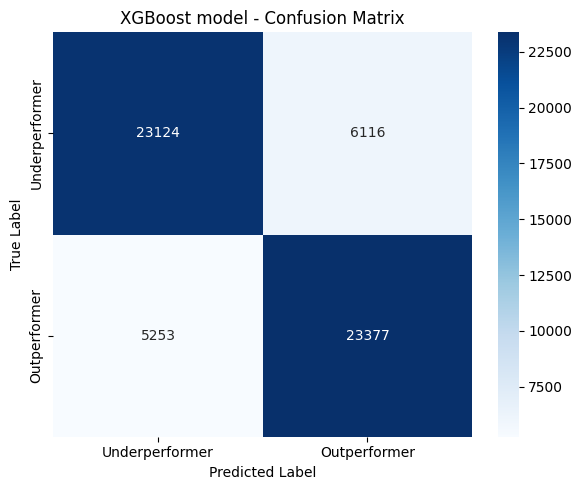

Accuracy: 0.80
Precision: 0.79
Recall: 0.82
F1 Score: 0.80


In [60]:
# Compute confusion matrix
plot_confusion_matrix(
    y_test_perf,
    perf_pred,
    labels=["Underperformer", "Outperformer"],
    title="XGBoost model - Confusion Matrix"
)

print_confusion_metrics(y_test_perf, perf_pred)

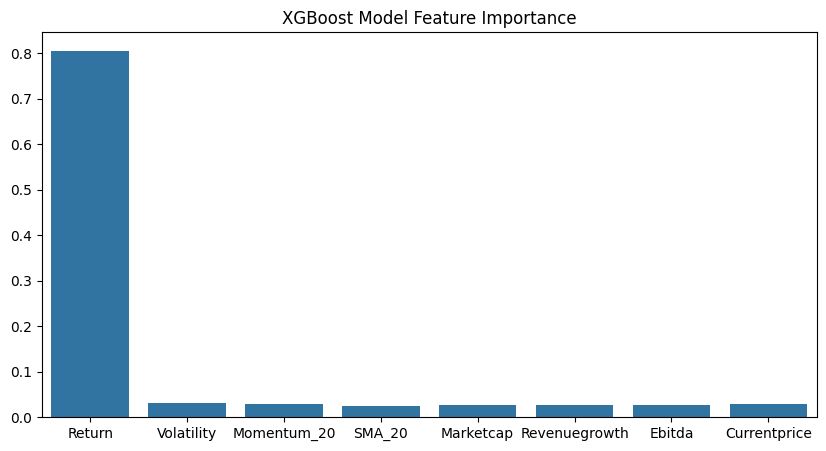

In [61]:
plt.figure(figsize=(10,5))
sns.barplot(x=feature_cols, y=perf_model.feature_importances_)
plt.title("XGBoost Model Feature Importance")
plt.show()

In [62]:
def dataEngineeringFor20DayPrediction(df):
    df['10d_return'] = df.groupby('Symbol')['Adj Close'].pct_change(10)
    df['Outperformer'] = (df['10d_return'] > df['10d_return'].median()).astype(int)
    # Calculate 20-day stock return
    df['Return_20d'] = df.groupby('Symbol')['Adj Close'].pct_change(20)

    # Calculate 20-day index return
    df['Index_Return_20d'] = df['S&P500'].pct_change(20)

    # Create the outperformer target:
    # If stock return > index return over same 20-day window
    df['Outperformer_20d'] = (df['Return_20d'] > df['Index_Return_20d']).astype(int)
    df['DateInt'] = df['Date'].astype(np.int64)
    return df

df_quantative_ml = dataEngineeringFor20DayPrediction(df_quantative_ml)

In [63]:
test, train = splitData(df_quantative_ml)

In [64]:
def scaleDataFor20Day(test, train):
    feature_cols = ["Return", "Volatility", "Momentum_20", "SMA_20", "Marketcap", "Revenuegrowth", "Ebitda", "Currentprice"]

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[feature_cols])
    X_test = scaler.transform(test[feature_cols])

    # Targets: 20-day Outperformance
    y_train = train['Outperformer_20d']
    y_test = test['Outperformer_20d']

    return X_train, X_test, y_train, y_test, feature_cols

X_train, X_test, y_train, y_test, feature_cols = scaleDataFor20Day(test, train)

In [65]:
# Train and evaluate the XGBoost model 2
model = XGBClassifier(n_estimators=100, random_state=42)

y_pred, y_pred_proba = train_and_evaluate(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name="XGBoost"
)

# Confusion matrix
print_confusion_metrics(y_test, y_pred)

# Save each KMeans model with the cluster count in the filename
model_path = os.path.join(SAVED_MODEL_DIR, 'XGBClassifier.pkl')
joblib.dump(model, model_path)

XGBoost Performance
Accuracy: 0.8284603421461897
AUC Score: 0.9183769083339695
Confusion Matrix:
 [[23569  6308]
 [ 3619 24374]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83     29877
           1       0.79      0.87      0.83     27993

    accuracy                           0.83     57870
   macro avg       0.83      0.83      0.83     57870
weighted avg       0.83      0.83      0.83     57870

Accuracy: 0.83
Precision: 0.79
Recall: 0.87
F1 Score: 0.83


['..\\saved_models\\XGBClassifier.pkl']

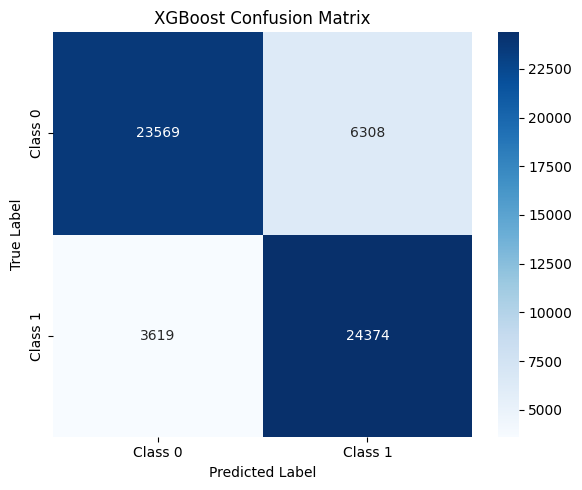

In [66]:
plot_confusion_matrix(y_test, y_pred, labels=["Class 0", "Class 1"], title="XGBoost Confusion Matrix")


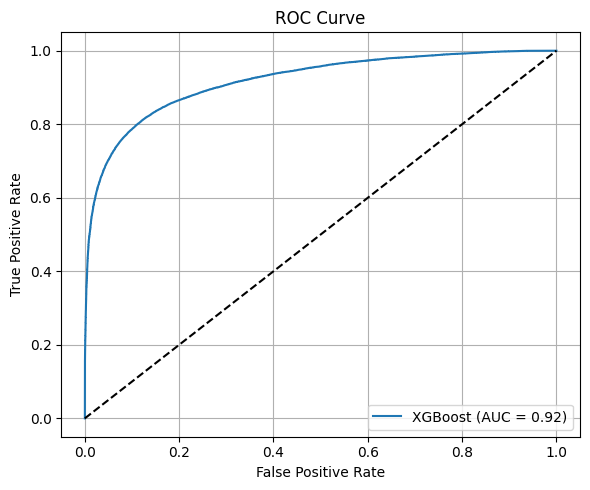

In [67]:
#Ploting the curve function
def plot_roc_curve(y_test, y_proba, label="Model"):
    # Check if y_proba is available
    if y_proba is None:
        print(f"ROC curve cannot be plotted for {label}: predict_proba not available.")
        return

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    # Use the imported auc function from sklearn.metrics
    roc_auc_value = auc(fpr, tpr) # This now correctly calls the imported function

    plt.figure(figsize=(6, 5))
    # Use the calculated scalar AUC value for the label
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_value:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.tight_layout()
    plt.show()

plot_roc_curve(y_test, y_pred_proba, label="XGBoost")

# Hyperparameter tuning


In [68]:
df_quantative_ml = pd.get_dummies(df_quantative_ml, columns=['Sector', 'Industry'])

In [69]:

def compute_rsi(series, length=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=length).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=length).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, fast=12, slow=26):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    return ema_fast - ema_slow

def compute_atr(df, length=14):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=length).mean()
    return atr

def compute_bollinger_band_width(series, length=20, num_std=2):
    sma = series.rolling(window=length).mean()
    std = series.rolling(window=length).std()
    upper = sma + num_std * std
    lower = sma - num_std * std
    return upper - lower

def compute_obv(close, volume):
    direction = np.sign(close.diff()).fillna(0)
    obv = (volume * direction).cumsum()
    return obv

def dataEngineeringForHyperParam(df):
    df = df.copy()

    # Replace pandas_ta indicators with manual ones
    df['RSI'] = compute_rsi(df['Close'])
    df['MACD'] = compute_macd(df['Close'])
    df['ATR'] = compute_atr(df)
    df['BB_width'] = compute_bollinger_band_width(df['Close'])
    df['OBV'] = compute_obv(df['Close'], df['Volume'])

    # Add rolling statistics
    df['Rolling_Return_5'] = df.groupby('Symbol')['Return'].rolling(5).mean().reset_index(0, drop=True)
    df['Rolling_Vol_5'] = df.groupby('Symbol')['Return'].rolling(5).std().reset_index(0, drop=True)

    # Final feature selection
    feature_cols = ['Return', 'Volatility', 'Momentum_20', 'SMA_20',
                    'Marketcap', 'Revenuegrowth', 'Ebitda', 'Currentprice']
    X = df[feature_cols]
    y = df['Outperformer_20d']

    return X, y, df


X, y,df_quantative_ml = dataEngineeringForHyperParam(df_quantative_ml)
print(df_quantative_ml.columns.tolist())


['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Exchange', 'Shortname', 'Longname', 'Currentprice', 'Marketcap', 'Ebitda', 'Revenuegrowth', 'City', 'State', 'Country', 'Fulltimeemployees', 'Longbusinesssummary', 'Weight', 'log1p_Revenuegrowth', 'log1p_Ebitda', 'S&P500', 'Daily Return', 'Return', 'Volatility', 'SMA_20', 'Momentum_20', 'Volatility_Lag', 'Momentum_20_Lag', 'Return_Lag', 'RiskClass', 'Outperformer', 'DateInt', '10d_return', 'Return_20d', 'Index_Return_20d', 'Outperformer_20d', 'Sector_Basic Materials', 'Sector_Communication Services', 'Sector_Consumer Cyclical', 'Sector_Consumer Defensive', 'Sector_Energy', 'Sector_Financial Services', 'Sector_Healthcare', 'Sector_Industrials', 'Sector_Real Estate', 'Sector_Technology', 'Sector_Utilities', 'Industry_Advertising Agencies', 'Industry_Aerospace & Defense', 'Industry_Airlines', 'Industry_Apparel Retail', 'Industry_Asset Management', 'Industry_Auto Manufacturers', 'Industry_Auto Parts', 'Industry_Beve

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Set up GridSearch
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


C:\Users\atul1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:31:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [71]:
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best CV Score: 0.8252425726079813


In [72]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
y_pred = best_model.predict(X_test)


              precision    recall  f1-score   support

           0       0.81      0.85      0.83     35430
           1       0.84      0.81      0.83     36985

    accuracy                           0.83     72415
   macro avg       0.83      0.83      0.83     72415
weighted avg       0.83      0.83      0.83     72415

Test Accuracy: 0.8254919560864462


In [73]:
# Save each KMeans model with the cluster count in the filename
model_path = os.path.join(SAVED_MODEL_DIR, 'best_model_XGB.pkl')
joblib.dump(best_model, model_path)

['..\\saved_models\\best_model_XGB.pkl']

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     35430
           1       0.84      0.81      0.83     36985

    accuracy                           0.83     72415
   macro avg       0.83      0.83      0.83     72415
weighted avg       0.83      0.83      0.83     72415

Test Accuracy: 0.8254919560864462


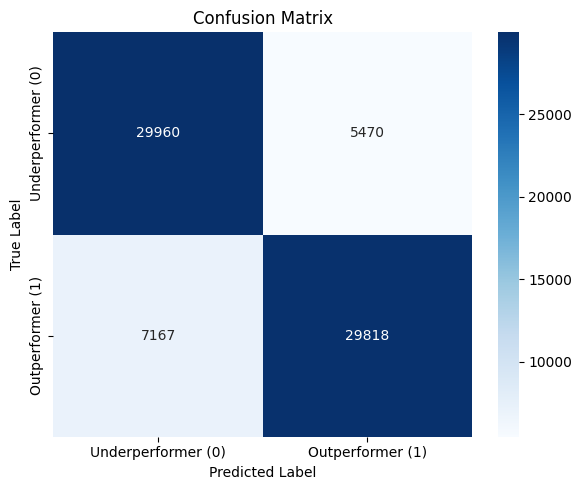

In [74]:
# Classification report
print(classification_report(y_test, y_pred))

# Accuracy score
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
plot_confusion_matrix(
    y_test,
    y_pred,
    labels=["Underperformer (0)", "Outperformer (1)"],
    title="Confusion Matrix"
)

Test ROC AUC: 0.7052


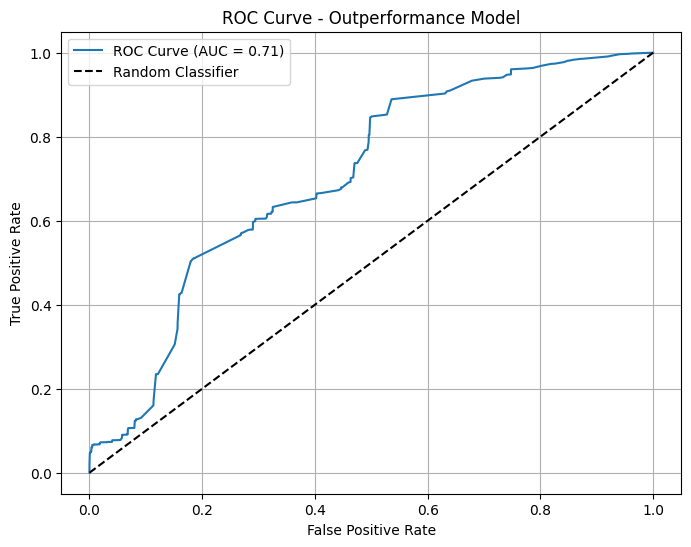

In [75]:
# Get predicted probabilities for the positive class
# Probability of class 1 (Outperformer)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC: {auc:.4f}")

# Calculate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Outperformance Model')
plt.legend()
plt.grid(True)
plt.show()